In [1]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

We must load the Python QNLP packages & module (`QNLP`), and the C++-Python bound simulator backend and algorithms (`PyQNLPSimulator`).

In [2]:
from PyQNLPSimulator import PyQNLPSimulator as p
import QNLP as q
import numpy as np
from QNLP import DisCoCat

from itertools import product
import tempfile

Next, we load the corpus file using the vector-space model, defined in the `VectorSpaceModel` class, specifying the mode of tagging, and whether to filter out stop-words.

In [3]:
vsm = q.VectorSpaceModel.VectorSpaceModel(
    corpus_path="/Users/mlxd/Desktop/qs_dev/intel-qnlp/corpus/11-0.txt", 
    mode='l', 
    stop_words=False
)

From here we can specify the number of basis elements by occurrence in the corpus.

In [4]:
num_basis_elems = 32
basis     = vsm.define_basis({'verbs' : num_basis_elems, 'nouns' : num_basis_elems})

In [5]:
verb_dist = vsm.sort_basis_tokens_by_dist("verbs", num_basis=num_basis_elems)
noun_dist = vsm.sort_basis_tokens_by_dist("nouns", num_basis=num_basis_elems)

We now take the previously defined basis elements, and attempt to arrange them such that the distance between nearest-neighbours in the corpus is minimised. With this, we assign a Gray code value to the basis. This allows us to ensure values closer together in the corpus have a shorter Hamming distance between them. We make use of the DisCo-inspired compositional model, wherein the distances between words dictates their closeness; we use these distances to define the edge-weights between nodes (tokens), and hence by defining the problem as a TSP, we can find an ordering that ensures Hamming distance relates directly to closeness of words.

In [6]:
vsm.assign_indexing("nouns");
vsm.assign_indexing("verbs")

{'nouns': {'March': 0,
  '”': 1,
  'Rabbit': 3,
  'Hare': 2,
  'voice': 6,
  'moment': 7,
  'tone': 5,
  'hand': 4,
  'Dormouse': 12,
  '“': 13,
  'Duchess': 15,
  'word': 14,
  'day': 10,
  'round': 11,
  'eye': 9,
  '*': 8,
  'Gryphon': 24,
  'Hatter': 25,
  'Gutenberg-tm': 27,
  'Mock': 26,
  'head': 30,
  'way': 31,
  'Turtle': 29,
  'King': 28,
  'time': 20,
  'Queen': 21,
  'Project': 23,
  'thing': 22,
  'work': 18,
  'Alice': 19,
  '‘': 17,
  '’': 16},
 'verbs': {'take': 0,
  'put': 1,
  'tell': 3,
  'looking': 2,
  'made': 6,
  'cried': 7,
  'asked': 5,
  'seemed': 4,
  'replied': 12,
  'come': 13,
  'added': 15,
  'took': 14,
  'going': 10,
  'felt': 11,
  'getting': 9,
  'get': 8,
  'found': 24,
  'make': 25,
  'came': 27,
  'think': 26,
  'looked': 30,
  'got': 31,
  'see': 29,
  'say': 28,
  'thought': 20,
  'go': 21,
  'began': 23,
  'know': 22,
  'went': 18,
  '‘': 19,
  '’': 17,
  'said': 16}}

Create `DisCoCat` object, and use to perform the mappings of basis tokens.

In [7]:
dcc = DisCoCat.DisCoCat()
mapping_verbs = dcc.map_to_basis(vsm.tokens['verbs'] , noun_dist['verbs'], basis_dist_cutoff=num_basis_elems)
mapping_nouns = dcc.map_to_basis(vsm.tokens['nouns'] , noun_dist['nouns'], basis_dist_cutoff=num_basis_elems)

Create graph of the resulting connected entities. Here we look at the mapping of specific noun tokens onto the noun basis.

In [8]:
import networkx as nx
g_nouns = nx.graph.Graph()
g_verbs = nx.graph.Graph()

#Add basis words to graph
for v in noun_dist['verbs']:
    g_verbs.add_node(v)
for v in noun_dist['nouns']:
    g_nouns.add_node(v)


In [9]:
# Add mapped/composite words to graph
for i in ['stocking', 'glove']: #['dawn', 'torrent']:
    g_nouns.add_node(i)

# Set connections between basis and mapped words
    for b_words,b_weights in mapping_nouns[i].items():
        g_nouns.add_edge(i, b_words, weight=b_weights)


In [10]:
#Remove unconnected basis words
uncon = list(nx.isolates(g_nouns))
g_nouns.remove_nodes_from(uncon)

# create diagram positions and edge labels
pos = nx.spring_layout(g_nouns, scale=5.0, k=20/np.sqrt(g_nouns.order())) #nx.bipartite_layout(g_nouns, nx.bipartite.sets(g_nouns)[0], scale=5) #nx.shell_layout(g_nouns, iterations=500)
labels = nx.get_edge_attributes(g_nouns,'weight')

#Colourmap for the nodes
cmap = []
for n in g_nouns:
    if n in noun_dist['nouns']:
        cmap.append('teal')
    else:
        cmap.append('plum')


In [12]:
############################################################
# Generate interactive graph from pyvis
############################################################
from pyvis.network import Network

G = Network(notebook=True, height="600px", width="100%", bgcolor="#222222", font_color="white")
G.repulsion() # Solver backend
G.show_buttons(filter_=['physics']) # Show sliders to control physics
#G.from_nx(g_nouns)

#Copy across edge weights with distance data
for n_token,n_attr in g_nouns.nodes(data=True):
    if n_token in noun_dist['nouns']:
        G.add_node(n_token, color="#007FFF", **n_attr)
    else:
        G.add_node(n_token, color="#008080", **n_attr)

#Copy across edge weights with distance data
for src,dest,e_attr in g_nouns.edges(data=True):
    G.add_edge(src,dest, width=2, color="#cccacb", title=int(e_attr.get("weight"))) #value=int(e_attr.get("weight")))

G.show("Composite_to_Basis_map_simple.html")

<IPython.core.display.Javascript object>


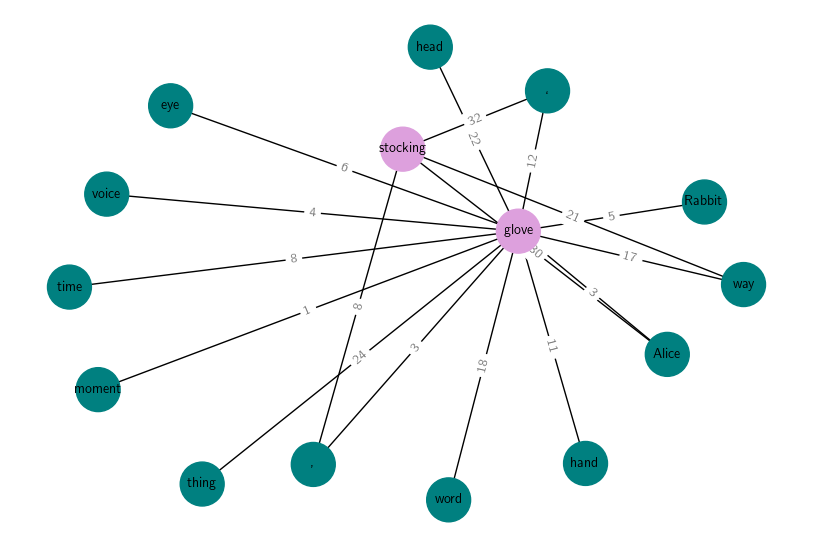

/Users/mlxd/Desktop/intel-qnlp-python/third_party/install/intel-qnlp_conda/envs/intel-qnlp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [13]:
# Generate static graph plot from networkx

nx.draw(g_nouns, pos=pos, with_labels=True, node_size=1000, node_color=cmap, font_size=10)
plt.margins(0.1)
nx.draw_networkx_edge_labels(g_nouns, pos, edge_labels=labels, alpha=0.5)

plt.savefig("Composite_to_Basis_map_simple.pdf", bbox_inches="tight")
plt.show()

# To be continued from here

From here, we define our encoding and decoding dictionaries.

In [7]:
# Define basis tokens encoding and decoding dicts
encoding_dict = {"ns" : vsm.encoded_tokens["nouns"],
                 "v"  : vsm.encoded_tokens["verbs"],
                 "no" : vsm.encoded_tokens["nouns"]
                }

decoding_dict = {"ns" : { v:k for k,v in encoding_dict["ns"].items() },
                 "v"  : { v:k for k,v in encoding_dict["v"].items() },
                 "no" : { v:k for k,v in encoding_dict["no"].items() }
                }

With the above information, we can now determine the required resources to store our data in a qubit register.

In [11]:
# Register must be large enough to support 2*|nouns| + |verbs|
len_reg_memory = len(verb_dist) + 2*len(noun_dist)
len_reg_ancilla = len_reg_memory + 2
num_qubits = len_reg_memory + len_reg_ancilla
print("""{}
Requires {} qubits to encode data using {} 
basis elements in each space, allowing a 
maximum of {} unique patterns.
{}
""".format("#"*48, num_qubits, num_basis_elems, 2**num_qubits, "#"*48)
)

################################################
Requires 14 qubits to encode data using 32 
basis elements in each space, allowing a 
maximum of 16384 unique patterns.
################################################



In [12]:
"""
Require analysis of corpus to determine number of patterns to encode. The current 
encoding method assumes unique patterns, though this can be extended to multiple 
occurrences of the same patterns later. Additionally, we can store 2^num_qubits 
unique patterns. As such, we will restrict the patterns to encode by limiting the
space over which we analyse the corpus-to-basis mapping.
"""
num_bin_pattern = 8

In [13]:
text = """
cats eat tuna.
dogs eat everything.
cats kill birds.
people feed dogs.
bakers use ingredients.
"""
import nltk
token_words = nltk.word_tokenize(text)
nltk.pos_tag(token_words)

[('cats', 'NNS'),
 ('eat', 'VBP'),
 ('tuna', 'NN'),
 ('.', '.'),
 ('dogs', 'NNS'),
 ('eat', 'VBD'),
 ('everything', 'NN'),
 ('.', '.'),
 ('cats', 'NNS'),
 ('kill', 'VBP'),
 ('birds', 'NNS'),
 ('.', '.'),
 ('people', 'NNS'),
 ('feed', 'VBP'),
 ('dogs', 'NNS'),
 ('.', '.'),
 ('bakers', 'NNS'),
 ('use', 'VBP'),
 ('ingredients', 'NNS'),
 ('.', '.')]

In [14]:
fp = tempfile.NamedTemporaryFile(mode='w')
fp.write(text);
fp.flush()

In [15]:
vsm2 = q.VectorSpaceModel.VectorSpaceModel(
    corpus_path=fp.name, 
    mode=0, 
    stop_words=False
)
fp.close()

In [16]:
num_basis_elems2 = 2
basis2     = vsm2.define_basis({'verbs' : num_basis_elems, 'nouns' : num_basis_elems})

verb_dist2 = vsm2.sort_basis_tokens_by_dist("verbs")
noun_dist2 = vsm2.sort_basis_tokens_by_dist("nouns")

In [17]:
vsm2.assign_indexing("nouns");
vsm2.assign_indexing("verbs")

{'nouns': {'bakers': 0,
  'ingredients': 1,
  'people': 3,
  'birds': 2,
  'everything': 6,
  'tuna': 7,
  'dogs': 5,
  'cats': 4},
 'verbs': {'use': 0, 'feed': 1, 'kill': 3, 'eat': 2}}

In [30]:
from QNLP import DisCoCat

In [39]:
dcc = DisCoCat.DisCoCat()

In [41]:
#def map_to_basis(self, corpus_list : list, basis : list, basis_dist_cutoff=10, distance_func=None):
dcc.map_to_basis(token_words, noun_dist2['verbs'], basis_dist_cutoff=2, distance_func=lambda )

{}

In [35]:
noun_dist2['verbs']

['use', 'feed', 'kill', 'eat']

In [36]:
token_words

['cats',
 'eat',
 'tuna',
 '.',
 'dogs',
 'eat',
 'everything',
 '.',
 'cats',
 'kill',
 'birds',
 '.',
 'people',
 'feed',
 'dogs',
 '.',
 'bakers',
 'use',
 'ingredients',
 '.']

In [44]:
dcc.distance_func([1,2,3,4,5])

[0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666]